<a href="https://colab.research.google.com/github/dona-eric/Computer-Vision/blob/main/Analyse/System_reconnaissance_emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, os, keras
import tensorflow as tf
warnings.filterwarnings('ignore')


In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"koulodjidonaric","key":"95fcf531548b38b55c74c0cfcdab41b8"}'}

In [5]:
import os
import shutil

# Créer un dossier .kaggle dans /root si non existant
os.makedirs("/root/.kaggle", exist_ok=True)

# Déplacer le fichier
shutil.move("kaggle.json", "/root/.kaggle/")

# Changer les permissions du fichier
os.chmod("/root/.kaggle/kaggle.json", 600)


In [6]:
# charger les données since kaggle
!kaggle datasets download -d msambare/fer2013


Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 71% 43.0M/60.3M [00:00<00:00, 153MB/s]
100% 60.3M/60.3M [00:00<00:00, 161MB/s]


In [7]:
# deziper

import zipfile

# Décompression du fichier ZIP
with zipfile.ZipFile("fer2013.zip", "r") as zip_ref:
    zip_ref.extractall("fer2013")

# Vérification du contenu
os.listdir("fer2013")


['train', 'test']

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import os, sys, time, datetime, random, cv2, warnings
warnings.filterwarnings("ignore")

In [11]:
## chargement des données

train_dataset = image_dataset_from_directory(
    "fer2013/train",
    image_size=(48, 48),
    shuffle=True,
    batch_size=32,
    color_mode="grayscale"
)

validation_dataset = image_dataset_from_directory(
    "fer2013/train",
    image_size=(48, 48),
    shuffle=True,
    batch_size=32,
    color_mode="grayscale",
)

test_dataset = image_dataset_from_directory(
    "fer2013/test",
    image_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
)

classes_names = train_dataset.class_names
print(classes_names)

Found 28709 files belonging to 7 classes.
Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


### Afficher quelques images

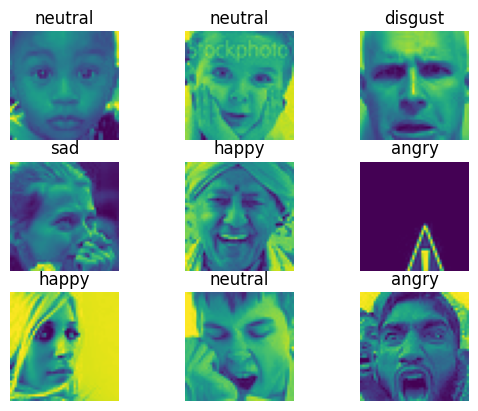

In [12]:
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes_names[labels[i]])
    plt.axis("off")
plt.show()

## understand the dataset

In [13]:
for batch_images, batch_labels in train_dataset:
  print(f"The shape of images are: {batch_images.shape}")
  print(f"The shape of labels are: {batch_labels.shape}")
  break

The shape of images are: (32, 48, 48, 1)
The shape of labels are: (32,)


## Apply the data augmentation

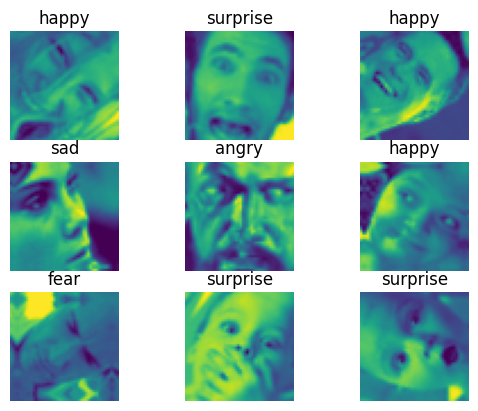

In [14]:
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
    ]
)

## display the images after apply the data augmentation

for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    images_augmented = data_augmentation(images)
    plt.imshow(images_augmented[i].numpy().astype("uint8"))
    plt.title(classes_names[labels[i]])
    plt.axis("off")
plt.show()

## Building the first model CNN(model0)

In [22]:
from typing import Optional
from re import X
inputs = Input(shape=(48, 48, 1))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0/255)(x)
## first layers convblock
## second layers convd
x = Conv2D(filters=32, kernel_size=3, activation='relu')(x)
# maxpooling
x = MaxPooling2D(pool_size=2)(x)
## third
x = Conv2D(filters=64, kernel_size=3, activation='relu')(x)
# maxpooling
x = MaxPooling2D(pool_size=2)(x)
## four
x= Conv2D(filters=128, kernel_size=3, activation='relu')(x)
# maxpooling
x = MaxPooling2D(pool_size=2)(x)
# five
x= Conv2D(filters=256, kernel_size=3, activation='relu', padding="same")(x)
# maxpooling
x = MaxPooling2D(pool_size=2)(x)
x = Conv2D(filters=256, kernel_size=3, activation='relu', padding='same')(x)
## couche d'applatissement
x = layers.Flatten()(x)
## minimisaton des images
x = layers.Dropout(0.5)(x)

outputs = Dense(units=7, activation='softmax')(x)

modelV0 = Model(inputs=inputs, outputs=outputs)

## model compiling
modelV0.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

modelV0.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 46, 46, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 21, 21, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 2, 2, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │           7,175 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 985,095 (3.76 MB)

 Trainable params: 985,095 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath='modelV0.keras',
    save_best_only=True,
    monitor='val_loss',
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
    )
]

## fitting the model

history = modelV0.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=callbacks,
)

Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 270s 297ms/step - accuracy: 0.2440 - loss: 1.8224 - val_accuracy: 0.2248 - val_loss: 1.7823
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 325s 300ms/step - accuracy: 0.2686 - loss: 1.7602 - val_accuracy: 0.3057 - val_loss: 1.7022
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 367s 350ms/step - accuracy: 0.3005 - loss: 1.7131 - val_accuracy: 0.3559 - val_loss: 1.6285
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 295s 320ms/step - accuracy: 0.3468 - loss: 1.6499 - val_accuracy: 0.3977 - val_loss: 1.5580
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 308s 342ms/step - accuracy: 0.3792 - loss: 1.5870 - val_accuracy: 0.4271 - val_loss: 1.4817
Epoch 6/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 304s 339ms/step - accuracy: 0.4029 - loss: 1.5365 - val_accuracy: 0.4515 - val_loss: 1.4357
Epoch 7/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 333s 351ms/step - accuracy: 0.4173 - loss: 1.4969 - val_accuracy: 0.4622 - val_loss: 1.3875
Epoch 8/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 362s 396ms/step - accuracy: 0.4292 -

## Visualisation de la fonction de perte et d'entrainement

In [ ]:
def plot_history(history):
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, "bo", label="Training accuracy")
  plt.plot(epochs, val_acc, "b", label="Validation accuracy")
  plt.title("Training and validation accuracy")
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, "bo", label="Training loss")
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.legend()
  plt.show()

## Testez modelV0

In [ ]:
test_model = keras.models.load_model("modelV0.keras")
test_loss_0, test_acc_0 = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc_0:.3f}")

## Using the model pre-trained VGG16 / MobileNet2 pour la légèreté



1.   Model VGG16
2.   Model MobileNet2
3. Model FaceNet



In [ ]:
### leverage VGG16

from tensorflow.keras.apllications import VGG16

conv_base = VGG16(
    weights = 'imagenet',
    include_bias = False,
    input_shape = (48, 48, 1)
)

# summary of paraameters model
conv_base.summary()

## Feature extraction without data augmentation

In [ ]:
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessing_images = VGG16.preprocess_input(images)
    features = conv_base.predict(preprocessing_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

## Building the model VGG16

In [ ]:
## identifier la dimension de l'image
train_features.shape

## modelisation de VGG16
inputs = Input(shape=())
x = layers.Dense(256, activation='relu')(inputs)
x = layers.Flatten(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(units=7, activation='softmax')(x)

modelVGG16_V1 = Model(inputs=inputs, outputs=outputs)

# model compile
modelVGG16_V1.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
## summary
modelVGG16_V1.summary()

In [ ]:
## using callbacks and fitting
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath='modelVGG16_V1.keras',
    save_best_only=True,
    monitor='val_loss',
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
    )
]

historyV1 = modelVGG16_V1.fit(
    train_features, train_labels,
    validation_data=(val_features, val_labels),
    epochs=50,
    callbacks=callbacks,
)

In [ ]:
## call the plot_history
plot_history(historyV1)

## Test the model pre-trained VGG16

In [ ]:
test_model = keras.models.load_model("modelVGG16_V1.keras")
test_loss_1, test_acc_1 = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc_1:.3f}")

## Identifying the models Weights before training the model VGG16

In [ ]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(48, 48, 3)
)
conv_base.trainable = False
print(len(conv_base.layers))
## trainable conv_base
conv_base.trainable = True
print(len(conv_base.layers))

### Modeling VGG16 with augmentation data

In [ ]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(48, 48, 1)
)

data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2),
    ]
)

inputs = Input(shape=(48, 48, 1))
x = data_augmentation(inputs)
#x = layers.Rescaling(1.0/255)(x)
x = VGG16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(units=7, activation='softmax')(x)

modelVGG16_V2 = Model(inputs=inputs, outputs=outputs)

modelVGG16_V2.compile(
    optimizer=RMSprop(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

modelVGG16_V2.summary()


## callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
    filepath='modelVGG16_V2.keras',
    save_best_only=True,
    monitor='val_loss',
    ),
    keras.callbacks(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
    )
]

## history
historyV2 = modelVGG16_V2.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=callbacks,
)

## ploting display
plot_history(historyV2)

# test the model

test_model = keras.models.load_model("modelVGG16_V2.keras")
test_loss_2, test_acc_2 = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc_2:.3f}")

## Resultats des models

In [ ]:
result_model = pd.DataFrame({
    'Model':["ModelV0", "ModelVGG16_V1", "ModelVGG16_V2"],
    'Accuracy':[test_acc_0, test_acc_1, test_acc_2],
    'Loss':[test_loss_0, test_loss_1, test_loss_2]
})

result_model.sort_values(by='Accuracy', ascending=False)